<a href="https://colab.research.google.com/github/vmcanseco/Prewave/blob/main/EUDR_Customer_API_Tutorial_%5BPublic%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

In [ ]:
import requests
import json
from google.colab import userdata

api_key = userdata.get('API_key')

base_url = "https://api.prewave.com"

headers = {
  'Content-Type': 'application/json',
  'X-Auth-Token': f"{api_key}"
}



* Prewave EUDR API is grouped by end user and this is reflected in the endpoint paths:
  * `eudr/customers` - endpoints for Prewave customers; these are the focus of this tutorial
  * `eudr/suppliers` - dedicated to suppliers of Prewave customers
  * `eudr/shared` - common endpoints useful for any integration
* Learn about endpoints and payloads in the [API Documentation](https://dev.prewave.com/#/EUDR)



# Products & Suppliers

## Create Product



*   Onboarding of product and suppliers with Excel  
*   Suppliers have to be already present when creating product
*   Any further set up of new suppliers can be done via [sites upsert API](https://dev.prewave.com/#/Sites%20Upsert/fullLoad)
*   Use Product Reference as identifier to link product in customer ERP system with Prewave



In [ ]:
# Data needed to create a product, available in customer ERP system

productName = "A Test Integration Product"
hsCode = "4001"
supplierName = "Fantasy Department For Testing 5"
supplierReference = "FD09876"


Internal Prewave supplier ID is required to create new product, use your supplier reference to find it with this endpoint:
https://dev.prewave.com/#/EUDR/findSuppliers

SMA status is also returned in the response.

In [ ]:
# Get internal Prewave supplier ID

url = f"{base_url}/public/v2/eudr/customers/suppliers?refs={supplierReference}"

response = requests.request("GET", url, headers=headers)

supplierId = response.json()[0]['id']

print(response.text)

[{"id":13756990,"name":"Fantasy Department for Testing 5 (Vienna)","location":"Vienna, AT","isPublic":true,"organization":{"id":13756981,"name":"Fantasy Department for Testing 5"},"screened":true,"references":[{"id":"FD09876","source":"ERP"}],"connectionContacts":[{"id":23147,"email":"alejandro.cruz+supplier@prewave.ai"},{"id":17726,"email":"pavol.knapo+supplier@prewave.ai"},{"id":39716,"email":"prem.anand@prewave.ai"},{"id":27820,"email":"susanna.bischof@prewave.ai"},{"id":23663,"email":"pavol.knapo+supplier20@prewave.ai"},{"id":22885,"email":"sumedha.sardana+supplier@prewave.ai"}],"supplierMaturity":{"answerStatus":"Good","answerHidden":false}}]


In [ ]:
# Alternatively supplier name to supplier ID mapping stored in customer ERP

suppliers = {"Fantasy Department For Testing 5":13756990}

New inbound product is created with this endpoint, internal Prewave product ID is returned in response: https://dev.prewave.com/#/EUDR/addInboundProduct

In [ ]:
# Create one inbound product, new product ID is returned in response

url = f"{base_url}/public/v2/eudr/customers/products/inbound"

payload = json.dumps({
  "name": productName,
  "hsCode": hsCode,
  "supplierId": supplierId
})

response = requests.request("POST", url, headers=headers, data=payload)

productId = int(response.text)

print(response.text)


33500


## Update Product


* Update product properties, for example product reference




In [ ]:
# Product reference udpated in customer ERP system

productReference = "TIP111222"

Any existing product can be updated with this endpoint: https://dev.prewave.com/#/EUDR/updateInboundProduct

In [ ]:
# Update one inbound product

url = f"{base_url}/public/v2/eudr/customers/products/inbound/{productId}"

payload = json.dumps({
  "name": productName,
  "reference": productReference,
  "hsCode": hsCode,
  "supplierId": supplierId
})

response = requests.request("PUT", url, headers=headers, data=payload)

print(response)


<Response [200]>


# Product Origin Requests

## Send Product Origin Request (POR)

*   Product origin request sent to supplier's connection contacts
*   Supplier contact added in onbarding with Excel
*   **PO, SN, other references** - You can add optional references—for example, a purchase order number from your ERP system—to help track the product origin request. You can also fetch the request and its references using our public API. A request without end date or weight will close as soon as the supplier provides and answer.
*   **End date** - The request with end date allows suppliers to send multiple answers over a set time. The request will automatically close on its specified end date. If you don't set an end date or a weight, the request will close as soon as a supplier responds.
*   **Weight (kg)** - You can set a weight in kilograms for this request, which allows suppliers to submit multiple answers until that total is reached. If both a weight and an end date are set, the end date takes priority, and the request will close then, regardless of whether the weight has been fulfilled.

Send origin request with this endpoint, only internal Prewave product ID is required, details of the origin request are returned in response: https://dev.prewave.com/#/EUDR/requestOrigins

In [ ]:
# Send origin request to supplier's connection contact

url = f"{base_url}/public/v2/eudr/customers/origin-requests"

payload = json.dumps({
  "items": [
    {
      # Mandatory properties:
      "productId": productId,


      # Optional properties:

      # Add optional references
      "references": [
          {
              "reference": "YOUR_PURCHASE_ORDER_NUMBER",
              "referenceType": "PurchaseOrder"
          },
          {
              "reference": "YOUR_BATCH_REFERENCE",
              "referenceType": "Other"
          }
      ],

      # Set end date for this origin request
      "endDate": "2025-10-31",

      # Set required weight for this origin request
      "requestedWeight": 1000,

      # Set contact ID if needed, otherwise leave it out of the request body
      # If not specified explicitly, POR is sent either to EUDR contacts or all contacts if no EUDR contact flagged
      # "connectionContactIds": [
      #   connectionContactId
      # ],

      # Add a comment to POR email sent to your supplier
      "comment": f"Product origins requested for {productName}, HS code : {hsCode}",

    }
  ]
})

response = requests.request("POST", url, headers=headers, data=payload)

print(response.text)


{"succeeded":[{"id":27031,"productId":64545,"createdAt":{"date":"2025-10-08T13:57:00.714179","_datetype_":"DateTime"},"status":"Requested","references":[{"reference":"YOUR_PURCHASE_ORDER_NUMBER","referenceType":"PurchaseOrder"},{"reference":"YOUR_BATCH_REFERENCE","referenceType":"Other"}]}],"failed":[],"status":"Succeeded"}


Connecation conact IDs are optional optional and if not specified explicitly, POR will be sent to contacts with is_eudr_contact (flag managed by Prewave CS) by default. If no contact has the  is_eudr_contact flag, then POR is sent to all connection contacts.
If you want to send the POR to a specific contact, use this endpoint with internal Prewave supplier ID to get list of contacts with IDs: https://dev.prewave.com/#/EUDR/findConnectionContacts

In [ ]:
# Get supplier's internal connection contact ID

url = f"{base_url}/public/v2/eudr/customers/suppliers/{supplierId}/connection-contacts"

response = requests.request("GET", url, headers=headers)

connectionContactId = response.json()[1]['id']

print(response.text)


[{"id":23147,"email":"alejandro.cruz+supplier@prewave.ai"},{"id":17726,"email":"pavol.knapo+supplier@prewave.ai"},{"id":27820,"email":"susanna.bischof@prewave.ai"},{"id":23663,"email":"pavol.knapo+supplier20@prewave.ai"},{"id":22885,"email":"sumedha.sardana+supplier@prewave.ai"}]


## Get Product Origin Requests


*   Check the origin request status, available statuses are Requested, Delayed, Rejected, Canceled, Answered, NotRequested
*   Get origin request data: orign IDs, supplier DDS references, reject or delay reasons
*   If the POR has been sent with requested weight and supplier has already answered, then the provided weight is returned in the response
*   If the POR has been sent with end date or weight, then the POR in in state Requested until end date or weight is reached, status changes to Answered after that
*   Once POR status is Answered, the origin IDs or supplier DDS references are returned in the response



Get the origins requests with this endpoint, internal Prewave product ID is requred, list of all origin requests are returned in response: https://dev.prewave.com/#/EUDR/findCustomerOriginRequests

In [ ]:
# Get origin requests

url = f"{base_url}/public/v2/eudr/customers/products/{productId}/origin-requests"

response = requests.request("GET", url, headers=headers)

print(json.dumps(response.json()['content'], indent=4))

[
    {
        "id": 27030,
        "status": "Requested",
        "createdAt": {
            "date": "2025-10-08T13:48:06.252668",
            "_datetype_": "DateTime"
        },
        "updatedAt": {
            "date": "2025-10-08T13:49:35.233591",
            "_datetype_": "DateTime"
        },
        "endDate": {
            "date": "2025-12-31",
            "_datetype_": "Date"
        },
        "requestedWeight": 1000,
        "providedWeight": 500.0,
        "references": [
            {
                "reference": "YOUR_PURCHASE_ORDER_NUMBER",
                "referenceType": "PurchaseOrder"
            },
            {
                "reference": "YOUR_BATCH_REFERENCE",
                "referenceType": "Other"
            }
        ]
    }
]


## Automation


*   Steps executed in Prewave enabling full automation with API integration
*   Configurable in UI (coming soon)
*   When origins from supplier received:
 *  Send DF checks
 *  (more coming soon)



## Get Product


*   Check if conditions are met for DDS
*   Use `ors` filter to filter products by POR status
*   See DF check results, SMA status, Legality Assesment score

Use this endpoint, internal Prewave product ID is reuired, you can use the `includeOrigins=false` flag to make the response lighter: https://dev.prewave.com/#/EUDR/findInboundProducts


In [ ]:
# Get one product

url = f"{base_url}/public/v2/eudr/customers/products/inbound?ids={productId}&includeOrigins=false"

response = requests.request("GET", url, headers=headers)

print(json.dumps(response.json()['content'], indent=4))


[
    {
        "id": 1359,
        "customerId": 14771,
        "orgId": 20027756,
        "name": "A new test ",
        "eudrScope": "EU",
        "commodity": {
            "id": 101355941,
            "name": "EUDR Cocoa"
        },
        "hsCode": {
            "code": "1801",
            "description": "COCOA AND COCOA PREPARATIONS / Cocoa beans, whole or broken, raw or roasted"
        },
        "countryRisk": "Mid",
        "origins": [],
        "hasPendingOriginRequest": true,
        "supplier": {
            "id": 13756990,
            "name": "Fantasy Department for Testing 5 (Vienna)",
            "type": "Site",
            "location": "Vienna, AT",
            "countryId": 2147102,
            "references": [
                {
                    "id": "FD09876",
                    "source": "ERP"
                }
            ]
        },
        "supplierDDS": [],
        "dfAssessment": {
            "status": "NonNegligible",
            "outdated": false,
    

# Due Diligence Statements

## Generate DDS

*   For invoces, shippments, purchase orders, customs
*   Create DDS draft first, then submit in the next step

In [ ]:
# Data needed to generate customer DDS for given product, available in customer ERP system

eoriNumber = "AT1234567890"
customerName = "Integration Company"
customerStreet = "Am Tbor 46"
customerCity = "Vienna"
customerPostalCode = "1020"
customerCountry = "Austria"
operatorType = "Operator"
activityType = "Export"
referenceType = "PurchaseOrder"
reference = "YOUR_PURCHASE_ORDER_NUMBER"
netWeightInKg = 250


Internal Prewave country ID is required to create new DDS, use this endpoint to get the IDs: https://dev.prewave.com/#/EUDR/findCountries

In [ ]:
# Country to internal country ID mapping

url = f"{base_url}/public/v2/eudr/shared/countries"

response = requests.request("GET", url, headers=headers)

data = response.json()

country_to_id = {item['name']: item['id'] for item in data}

data[:2]

[{'id': 2147093,
  'name': 'Afghanistan',
  'countryCode': 'AF',
  'bounds': {'type': 'Polygon',
   'coordinates': [[[60.504166, 29.406105],
     [60.504166, 38.472115],
     [74.915741, 38.472115],
     [74.915741, 29.406105],
     [60.504166, 29.406105]]]}},
 {'id': 2147096,
  'name': 'Albania',
  'countryCode': 'AL',
  'bounds': {'type': 'Polygon',
   'coordinates': [[[19.282497, 39.644722],
     [19.282497, 42.661942],
     [21.054165, 42.661942],
     [21.054165, 39.644722],
     [19.282497, 39.644722]]]}}]

Create new DDS draft with this endpoint, DDS details including internal Prewave ID are returned in the response: https://dev.prewave.com/#/EUDR/addCustomerDDS

In [ ]:
# Generate customer DDS

url = f"{base_url}/public/v2/eudr/customers/products/64421/customer-dds"

payload = json.dumps({

    # Mandatory properties:
    "eoriNumber": eoriNumber,
    "customerName": customerName,
    "customerStreet": customerStreet,
    "customerCity": customerCity,
    "customerPostalCode": customerPostalCode,
    "customerCountryId": country_to_id[customerCountry],
    "operatorType": "Operator",
    "activityType": "Import",
    "date": "2025-02-27T12:40:28.543Z",
    "netWeightInKg": netWeightInKg,
    "quantity": "",
    "unit": "",

    # Optional properties:
    "originRequestReferences": [
    {
      "reference": [
        reference
      ],
      "type": referenceType
    }
    ],
    "referencedDDSs": [
    "25ATGPIMUB1448"
    ]
})

response = requests.request("POST", url, headers=headers, data=payload)

ddsId = int(response.json()['id'])

print(json.dumps(response.json(), indent=4))


{
    "id": 639,
    "active": true,
    "date": {
        "date": "2025-02-27T12:40:28.543",
        "_datetype_": "DateTime"
    },
    "archived": false,
    "origins": [],
    "eoriNumber": "AT1234567890",
    "customerName": "Integration Company",
    "customerCity": "Vienna",
    "customerPostalCode": "1020",
    "customerStreet": "Am Tbor 46",
    "customerCountry": {
        "id": 2147102,
        "name": "Austria",
        "countryCode": "AT",
        "bounds": {
            "type": "Polygon",
            "coordinates": [
                [
                    [
                        9.533569,
                        46.407494
                    ],
                    [
                        9.533569,
                        49.018883
                    ],
                    [
                        17.166386,
                        49.018883
                    ],
                    [
                        17.166386,
                        46.407494
              

## Submit DDS

*   Submit DDS to Traces NT
*   Use internal Prewave DDS ID in this endpoint:

Use this endpoint to submit draft DDS, internal Prewave DDS ID is required:
https://dev.prewave.com/#/EUDR/submitCustomerDDS

In [ ]:
# Sumbit DDS to Traces NT
# USE WITH CAUTION ON PRODUCTION SYSTEM, ANY DDS IN TRACES NT PRODUCTION IS LEGALLY BINDING DOCUMENT

url = f"{base_url}/public/v2/eudr/customers/customer-dds/{ddsId}/submission"

response = requests.request("PUT", url, headers=headers)

print(response)


## Get Customer DDS


*   Get the latest active DDS with reference and verification numbers if submitted to Traces
*   Get all previous DDSs sorted by date, the latest DDSs is the first item in the list
*   For invoces, shippments, purchase orders, customs
*   Check validity, date of expiry

Use this edpoint, internal Prewave product ID is required:
https://dev.prewave.com/#/EUDR/findCustomerDDS



In [ ]:
# Get customer DDS for one product

url = f"{base_url}/public/v2/eudr/customers/products/{productId}/customer-dds"

response = requests.request("GET", url, headers=headers)

print(json.dumps(response.json(), indent=4))


[
    {
        "id": 243,
        "active": true,
        "referenceNumber": "582ba221-b04e-43f0-9f11-e6f939c38a5a",
        "verificationNumber": "abb5fa4d5bba4148913f4956f13b7145",
        "date": {
            "date": "2025-02-27T12:40:28.543",
            "_datetype_": "DateTime"
        },
        "archived": false,
        "origins": [
            {
                "id": 372,
                "name": "Parque Do Xingu",
                "active": true,
                "producedAtStart": {
                    "date": "2024-09-25T15:06:34.574",
                    "_datetype_": "DateTime"
                },
                "producedAtEnd": {
                    "date": "2024-09-25T15:06:34.574",
                    "_datetype_": "DateTime"
                },
                "producer": {
                    "id": 13756990,
                    "name": "Fantasy Department for Testing 5 (Vienna)",
                    "countryId": 2147102
                },
                "country": {
 

## Get Supplier DDSs

*   See all supplier DDSs for a given product
*   Get DDS references

Use this endpoint, internal Prewave product ID is required, list of supplier DDS is is returned in response: https://dev.prewave.com/#/EUDR/findSupplierDDS

In [ ]:
# Get supplier DDSs for one product

url = f"{base_url}/public/v2/eudr/customers/products/{productId}/supplier-dds"

response = requests.request("GET", url, headers=headers)

print(json.dumps(response.json(), indent=4))

[
    {
        "id": 392,
        "active": true,
        "euReference": "9dc0f1b5-c9b6-4000-bda4-c396fe3ba70f",
        "date": {
            "date": "2025-02-27T12:40:28.543",
            "_datetype_": "DateTime"
        },
        "archived": false
    },
    {
        "id": 393,
        "active": true,
        "euReference": "ac4faea5-b10d-4d11-b963-a4fdabc8ad7b",
        "date": {
            "date": "2025-08-19T00:00:00",
            "_datetype_": "DateTime"
        },
        "archived": false
    }
]


# Other

## Create Outbound Product

*   Create new outbound product
*   Link inbound prodducts

https://dev.prewave.com/#/EUDR/addOutboundProduct

In [ ]:
# Data needed to create a product, available in customer ERP system

productName = "A Integration Outbound Product"
productReference = "TIOP333444"
hsCode = "1806"
annualQuantity = 6000
annualRevenue = 45000


Internal Prewave commodity ID is reuired to create new product, use this endpoint to get it: https://dev.prewave.com/#/EUDR/findHSCodes

In [ ]:
# HS codes to internal commodity ID mapping

url = f"{base_url}/public/v2/eudr/shared/hscodes"

response = requests.request("GET", url, headers=headers)

data = response.json()

code_to_commodity = {item['code']: item['commodityId'] for item in data}

data[:5]

[{'code': '01', 'description': 'LIVE ANIMALS', 'commodityId': 101941945},
 {'code': '010221',
  'description': 'LIVE ANIMALS / Live bovine animals; Cattle',
  'commodityId': 101355938},
 {'code': '01022110',
  'description': 'LIVE ANIMALS / Live bovine animals; Cattle; Heifers (female bovines that have never calved)',
  'commodityId': 101355938},
 {'code': '01022130',
  'description': 'LIVE ANIMALS / Live bovine animals; Cattle; Cows',
  'commodityId': 101355938},
 {'code': '01022190',
  'description': 'LIVE ANIMALS / Live bovine animals; Cattle; Other',
  'commodityId': 101355938}]

New outbound product is created with this endpoint, internal Prewave product ID is returned in response: https://dev.prewave.com/#/EUDR/addOutboundProduct

In [ ]:
# Create new outbound product

url = f"{base_url}/public/v2/eudr/customers/products/outbound"

commodityId = code_to_commodity[hsCode]

payload = json.dumps({
  "name": productName,
  "scientificName": "",
  "reference": productReference,
  "commodityId": commodityId,
  "hsCode": hsCode,
  "annualRevenue": annualRevenue,
  "annualQuantity": annualQuantity,
  "unit": "kg"
})

response = requests.request("POST", url, headers=headers, data=payload)

productId = int(response.text)

print(f"New outbound product created, ID: {productId}")

New outbound product created, ID: 3821


In [ ]:
# List of inbound product references that link to outbound, available in customer ERP

inboundProductReferences = ["050405", "515566", "524962"]


In [ ]:
# Filter by product reference to get product IDs using query parameter

inboundProductIds =[]

for inboundProductRef in inboundProductReferences:

  url = f"{base_url}/public/v2/eudr/customers/products/inbound?q={inboundProductRef}&includeOrigins=false&page=0&size=10"

  response = requests.request("GET", url, headers=headers)

  for product in response.json()['content']:
    inboundProductIds.append(product['id'])

print(inboundProductIds)

[703, 729, 776]


Use this endpoint to link inbound with outbound, list of internal Prewave inbound product IDs is required: https://dev.prewave.com/#/EUDR/addOutboundInboundProducts

In [ ]:
# Link inbound products to outbound product

url = f"{base_url}/public/v2/eudr/customers/products/outbound/{productId}/inbound"

payload = json.dumps({
  "inboundProductIds": inboundProductIds
})

response = requests.request("POST", url, headers=headers, data=payload)

print(response)


<Response [200]>


Use this endpoint to unlink inbound from outbound, list of internal Prewave inbound product IDs is required: https://dev.prewave.com/#/EUDR/removeOutboundInboundProduct

In [ ]:
# Unlink inbound product from outbound product

unlinkProductId = inboundProductIds[0]

url = f"{base_url}/public/v2/eudr/products/customers/outbound/{productId}/inbound/{unlinkProductId}"

payload = json.dumps({
  "inboundProductIds": inboundProductIds
})

response = requests.request("DELETE", url, headers=headers, data=payload)

print(response)

<Response [200]>


## Filter Product Data


*   Filters products with selected properties
*   Use for reporting



In [ ]:
# Filter inbound products with non-negligible deforestation checks and get their origins

filter = "dfs=NonNegligible"

url = f"{base_url}/public/v2/eudr/customers/products/inbound?{filter}&includeOrigins=false&page=0&size=10"

response = requests.request("GET", url, headers=headers)

print(json.dumps(response.json()['content'], indent=4))


[
    {
        "id": 2975,
        "customerId": 14771,
        "orgId": 20027756,
        "name": "A Test Integration Product",
        "scientificName": "",
        "reference": "TIP111222",
        "eudrScope": "EU",
        "commodity": {
            "id": 101355941,
            "name": "EUDR Cocoa"
        },
        "hsCode": {
            "code": "1801",
            "description": "COCOA AND COCOA PREPARATIONS / Cocoa beans, whole or broken, raw or roasted"
        },
        "annualSpend": 1000,
        "annualQuantity": 5500,
        "unit": "kg",
        "countryRisk": "Mid",
        "origins": [],
        "hasPendingOriginRequest": false,
        "supplier": {
            "id": 13756990,
            "name": "Fantasy Department for Testing 5 (Vienna)",
            "type": "Site",
            "location": "Vienna, AT",
            "countryId": 2147102
        },
        "supplierDDS": [],
        "dfAssessment": {
            "status": "NonNegligible",
            "outdated": 

In [ ]:
# Filter products with blocked DDS

filter = "dd=Blocked"

url = f"{base_url}/public/v2/eudr/customers/products/inbound?{filter}&includeOrigins=false&page=0&size=10"

response = requests.request("GET", url, headers=headers)

print(json.dumps(response.json()['content'], indent=4))

[
    {
        "id": 3756,
        "customerId": 14771,
        "orgId": 20027756,
        "name": "A virtual site supplier",
        "eudrScope": "Import",
        "commodity": {
            "id": 101355937,
            "name": "EUDR Rubber"
        },
        "hsCode": {
            "code": "4001",
            "description": "RUBBER AND ARTICLES THEREOF / Natural rubber, balata, gutta-percha, guayule, chicle and similar natural gums, in primary forms or in plates, sheets or strip"
        },
        "countryRisk": "Mid",
        "origins": [],
        "hasPendingOriginRequest": false,
        "supplier": {
            "id": 102430608,
            "name": "SIEMENS SWITZERLAND LTD.",
            "type": "Site",
            "location": "Zug, CH",
            "countryId": 2147133
        },
        "supplierDDS": [],
        "dfAssessment": {
            "status": "Negligible",
            "outdated": false,
            "checkType": "Basic"
        },
        "ddsStatus": {
            

In [ ]:
# Filter by product name, supplier or product reference using query parameter

filter = "q=Cocoa"

url = f"{base_url}/public/v2/eudr/customers/products/inbound?{filter}&includeOrigins=false&page=0&size=10"

response = requests.request("GET", url, headers=headers)

print(json.dumps(response.json()['content'], indent=4))

[
    {
        "id": 716,
        "customerId": 14771,
        "orgId": 20027756,
        "name": "Certified Cocoa Beans",
        "scientificName": "",
        "reference": "695253",
        "eudrScope": "EU",
        "commodity": {
            "id": 101355941,
            "name": "EUDR Cocoa"
        },
        "hsCode": {
            "code": "1802",
            "description": "COCOA AND COCOA PREPARATIONS / Cocoa shells, husks, skins and other cocoa waste"
        },
        "annualSpend": 3148230,
        "annualQuantity": 37038,
        "unit": "kg",
        "countryRisk": "Mid",
        "origins": [],
        "hasPendingOriginRequest": false,
        "supplier": {
            "id": 101123013,
            "name": "fantasy department for testing 3 (Paris) ",
            "type": "Site",
            "location": "Paris, FR",
            "countryId": 2147165
        },
        "supplierDDS": [],
        "dfAssessment": {
            "status": "Negligible",
            "outdated": fals

## Get All Product Data


*   Endpoint is paginated
*   Loop to get all product data
*   The response might take several minutes depending on the number of products



In [ ]:
# Get all products, filter our origins for faster response. Getting all products data can take several minutes.

urls = [
    f"{base_url}/public/v2/eudr/customers/products/inbound?includeOrigins=false",
    f"{base_url}/public/v2/eudr/customers/products/outbound?includeOrigins=false"
]

data = []

for url in urls:
    response = requests.get(url, headers=headers)

    for page in range(response.json()["totalPages"]+1):
      response = requests.get(url+f"&page={page}", headers=headers)

      # Check if the response is successful
      if response.status_code == 200:
          json_data = response.json()["content"]

          # Ensure that the response is a list
          if isinstance(json_data, list):
              data.extend(json_data)
          else:
              print(f"Unexpected data format from {url}: Expected a list.")
      else:
          print(f"Failed to fetch data from {url}. Status code: {response.status_code}")

# 'data' as a flat list containing all JSON objects from both responses
print(f"{len(data)} products")

240 products


In [ ]:
data[:2]

[{'id': 2608,
  'customerId': 14771,
  'orgId': 20027756,
  'name': 'A advanced DF',
  'eudrScope': 'EU',
  'commodity': {'id': 101355941, 'name': 'EUDR Cocoa'},
  'hsCode': {'code': '1801',
   'description': 'COCOA AND COCOA PREPARATIONS / Cocoa beans, whole or broken, raw or roasted'},
  'annualQuantity': 1000,
  'countryRisk': 'Mid',
  'origins': [],
  'hasPendingOriginRequest': False,
  'supplier': {'id': 13756990,
   'name': 'Fantasy Department for Testing 5 (Vienna)',
   'type': 'Site',
   'location': 'Vienna, AT',
   'countryId': 2147102},
  'supplierDDS': [],
  'dfAssessment': {'status': 'Negligible',
   'outdated': False,
   'checkType': 'Advanced'},
  'ddsStatus': {'status': 'Allowed'},
  'supplierMaturity': {'status': 'Accepted',
   'grading': 'Good',
   'inProgress': False,
   'lastRequestedAt': {'date': '2024-12-06T09:47:35',
    '_datetype_': 'DateTime'},
   'lastUpdatedAt': {'date': '2024-10-16T14:31:58', '_datetype_': 'DateTime'}},
  'legalityAssessment': {'minScore': {

## DDS Status Reporting


*   Get status of DDSs
*   Show as table
*   Calculate EUDR compliance score
*   Create high level chart for compliance status



In [ ]:
# Report product DDS status

import pandas as pd

product_data = []

for item in data:
  try:
    product_name = item.get('name', 'N/A')
    supplier_name = item.get('supplier', {}).get('name', 'N/A')
    dds_status = item.get('ddsStatus', {}).get('status', 'N/A')
    dds_status_reason = item.get('ddsStatus', {}).get('reason', 'N/A')

    product_data.append({
        'Product Name': product_name,
        'Supplier Name': supplier_name,
        'DDS Status': dds_status,
        'DDS Status Reason': dds_status_reason
    })
  except AttributeError:
    # Handle cases where 'supplier' might not be a dictionary
    print(f"Skipping an item due to a missing or invalid 'supplier' field")
    continue

# Create a Pandas DataFrame from the extracted product data
df = pd.DataFrame(product_data)

df


,Product Name,Supplier Name,DDS Status,DDS Status Reason
0,A advanced DF,Fantasy Department for Testing 5 (Vienna),Allowed,N/A
1,A coffee,Fantasy Department for Testing 5 (Vienna),SubmissionError,N/A
2,A new DF check,Fantasy Department for Testing 5 (Vienna),Allowed,N/A
3,A new test,Fantasy Department for Testing 5 (Vienna),WaitingForOrigins,NoOrigins
4,A Test Integration Product,Fantasy Department for Testing 5 (Vienna),Available,N/A
...,...,...,...,...
207,Raw Cattle,N/A,Blocked,N/A
208,Raw Cattle,N/A,Blocked,N/A
209,Raw Cocoa Beans,N/A,Blocked,N/A
210,Raw Timber Logs,N/A,Blocked,N/A


In [ ]:
# High level EUDR compliance stats

complaint_count = df[df['DDS Status'].isin(['Allowed', 'Available', 'Draft'])].shape[0]
noncompliant_count = df[df['DDS Status'].isin(['Blocked', 'WaitingForOrigins'])].shape[0]
compliance_percentage = (complaint_count / (complaint_count + noncompliant_count)) * 100

print(f"Compliant products: {complaint_count}")
print(f"Non-compliant products: {noncompliant_count}")
print(f"Product compliance score: {compliance_percentage:.0f}%")

Compliant products: 48
Non-compliant products: 163
Product compliance score: 23%


In [ ]:
# Product DDS status stats
grouped_df = df.groupby('DDS Status')

grouped_df.size()

,0
DDS Status,
Allowed,43
Available,3
Blocked,158
Draft,2
SubmissionError,1
WaitingForOrigins,5


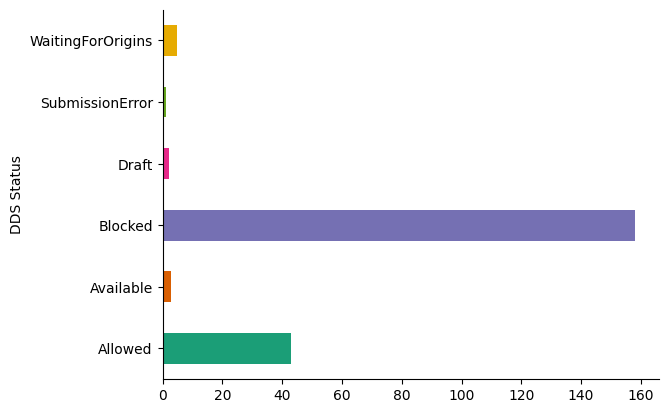

In [ ]:
# DDS Status

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('DDS Status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## DDS Validity Check


*   Get list of available DDSs
*   Check validity period to stay compliant



In [ ]:
# Filter products with avaiable DDS

filter = "dd=Available"

urls = [
    f"{base_url}/public/v2/eudr/customers/products/inbound?{filter}&includeOrigins=false",
    f"{base_url}/public/v2/eudr/customers/products/outbound?{filter}&includeOrigins=false"
]

data = []

for url in urls:
    response = requests.get(url, headers=headers)

    for page in range(response.json()["totalPages"]+1):
      response = requests.get(url+f"&page={page}", headers=headers)

      # Check if the response is successful
      if response.status_code == 200:
          json_data = response.json()["content"]

          # Ensure that the response is a list
          if isinstance(json_data, list):
              data.extend(json_data)
          else:
              print(f"Unexpected data format from {url}: Expected a list.")
      else:
          print(f"Failed to fetch data from {url}. Status code: {response.status_code}")

In [ ]:
# Get list of product IDs with available DDSs

id_list = []

for item in data:
  try:
    id_list.append(item['id'])
  except KeyError:
    print(f"Skipping an item due to a missing 'id' field")
    continue

availableDDS = []


# Get avaiable customer DDSs

for id in id_list:

  url = f"{base_url}/public/v2/eudr/customers/products/{id}/customer-dds"

  response = requests.request("GET", url, headers=headers)

  availableDDS.extend(response.json())

# print(json.dumps(availableDDS, indent=4))

In [ ]:
# Calculate DDS validity period

import pandas as pd
from datetime import datetime

def calculate_day_difference(timestamp_str):
  try:
    timestamp = datetime.fromisoformat(timestamp_str.replace('Z', '+00:00'))
    today = datetime.now()
    difference = today - timestamp
    return 365 - difference.days
  except ValueError:
    return None

DDS_data = []

for item in availableDDS:
  try:
    product_name = item.get('productName', 'N/A')
    hs_code = item.get('hsCode', 'N/A')
    net_weight = item.get('netWeightInKg', 'N/A')
    dds_reference = item.get('referenceNumber', 'N/A')
    date = item.get('date', {}).get('date', 'N/A')

    DDS_data.append({
        'Product Name': product_name,
        'HS Code': hs_code,
        'Net Weight Kg': net_weight,
        'DDS Reference': dds_reference,
        'Date': date
    })
  except AttributeError:
    # Handle errors
    print(f"Skipping an item due to a missing or invalid field")
    continue

# Create a Pandas DataFrame from the extracted product data
df = pd.DataFrame(DDS_data)

# Calculate DDS age
if 'Date' in df.columns:
  df['Validity Days'] = df['Date'].apply(calculate_day_difference)

df_sorted = df.sort_values('Validity Days')
df_sorted


,Product Name,HS Code,Net Weight Kg,DDS Reference,Date,Validity Days
2,Certified Robusta Coffee,0901,1000,25ATGPIMUB1448,2025-01-22T01:00:00,273
0,A Test Integration Product,1801,1000,25ATWVO6WR5637,2025-02-27T12:40:28.543,309
1,Certified Arabica Coffee,0901,1000,25ATSPVY7O5612,2025-04-24T02:00:00,365


# EUDR API Changes

*Prewave EUDR endpoints change log*

---
# **2025.20.0 4 Nov 2025**

## **Date not needed when submitting DDS**

Date is now automatically filled when DDS is submitted in UI and via API.

/public/v2/eudr/customers/products/{productId}/customer-dds

Mandatory **date** property dropped from the request body.

---
# **2025.19.0 21 Oct 2025**

## **Search my suppliers by reference or target ID**

Search by supplier references or target IDs is now supported. This endpoint returns only customer own suppliers.

/public/v2/eudr/customers/suppliers (GET)

**refs** or **targetIds** parameters added. It is possible to search up to 100 refs or targetIds. Response body is lighter and contains only EUDR relevant data.

## **Search all companies**

Search of all companies in Prewave have been separated to this new path.

/public/v2/eudr/customers/suppliers/search (GET)

**query** parameter is used to match by name or other available information. Returns maximum 100 results.

## **Inbound, outbound filters improved**

Filters have been improved and simplified.

/public/v2/eudr/customers/products/inbound

/public/v2/eudr/customers/products/outbound

Filter by product origin request status added in inbound, **ors** (Requested, Delayed, Rejected, Canceled, Answered)  

## **SMA status in inbound and suppliers endpoints**

SMA status is now included in following endpoints:

/public/v2/eudr/customers/products/inbound

/public/v2/eudr/customers/suppliers

**supplierMaturity** object has **answerStatus** (Requested, InProgress, Good, Critical), **answerHidden** (true, false) properties and timestamps **lastRequestedAt, lastUpdatedAt**


---

# **2025.18.0 7 Oct 2025**

## **Traces NT address changes**

Single address line has been replaced by 3 inputs: street, city, postal code. This is reflected in the UI and the API.

/public/v2/eudr/customers/products/{productId}/customer-dds (POST)

**customerAddress** replaced by **customerStreet**, **customerCity**, **customerPostalCode**

/public/v2/eudr/customers/products/{productId}/customer-dds (GET)

**customerAddress** replaced by **customerStreet**, **customerCity**, **customerPostalCode**

## **Traces NT country of activity optional**

Country of activity is now optional, change has been reflected in the UI and API.

/public/v2/eudr/customers/products/{productId}/customer-dds (POST)

**countryOfActivityId** is optional property in the request body

## **Traces NT supplementary units**

Support for supplementary units for required HS codes from recent Traces update, see [Traces documentation](https://circabc.europa.eu/ui/group/34861680-e799-4d7c-bbad-da83c45da458/library/d3b529b5-f62b-4b9f-abad-29f22e828a9b/details) for more info.

/public/v2/eudr/customers/products/{productId}/customer-dds (POST)

Existing **unit** property now accepts NAR, MTQ, KSD units for required HS codes.

## **Origin requests endpoint simplified**

/public/v2/eudr/customers/origin-requests (POST)

**supplierId** property dropped from the request body as productId represents product-supplier combination. Response body is lighter and the **product** object has been dropped.

## **Product endpoints simplified**

HS code \- commodity mapping step is no longer required for product endpoints.

/public/v2/eudr/customers/products/inbound (POST)

/public/v2/eudr/customers/products/outbound (POST)

**commodityId** property has been dropped from the request body.

## **Origin requests with weight**

Optional weight property can be added when sending product origin requests. The POR stays open until supplier provides required weight in one or multiple consecutive answers.

### **Customer APIs**

/public/v2/eudr/customers/origin-requests (POST)

Optional **requestedWeight** property can be specified in the request body. The POR stays open until the the requested weight is reached allowing supplier multiple answers at different times.

/public/v2/eudr/customers/products/{productId}/origin-requests (GET)

If specified, **requestedWeight** property returned in payload. If supplier provided any weight with origins or supplier DDSs, **providedWeight** will be returned in payload as well.

### **Supplier APIs**

/public/v2/eudr/suppliers/origin-requests (GET)

If specified, **requestedWeight** and **providedWeight** properties returned in response payload.

## **Origin requests connection contacts optional**

Connection contact IDs have been made optional and if not specified explicitly, POR will be sent to contacts with is\_eudr\_contact (flag managed by Prewave CS) by default. If no contact has the is\_eudr\_contact flag, then POR is sent to all connection contacts.

/public/v2/eudr/customers/origin-requests (POST)

Existing **connectionContactIds** property is now optional in the request body.

## **Supplier reference in inbound endpoint**

/public/v2/eudr/customers/products/inbound (GET)

User defined supplier **references** object has been added with properties **id** (ie. “123”) and **source** (ie. “SAP”)

---

# **2025.17.0 23 Sep 2025**

## **Origin requests with end date**

Optional end date property added to product origin requests.

### **Customer APIs**

/public/v2/eudr/customers/origin-requests (POST)

Optional **endDate** property can be specified in the request body. The POR stays open until the end date allowing supplier multiple answers at different times.

/public/v2/eudr/customers/products/{productId}/origin-requests (GET)

If specified, **endDate** property returned in payload.

### **Supplier APIs**

/public/v2/eudr/suppliers/origin-requests (GET)

If specified, **endDate** property returned in payload.

/public/v2/eudr/suppliers/origin-requests/{originRequestId}/supplier-dds (POST)

If endDate set by customer, supplier will be able to share supplier DDSs until the POR expires.

---

# **2025.16.0 16 Sep 2025**

## **Reference properties renamed**

Minor property renaming updates released in 2025.16.0 in endpoints:

/public/v2/eudr/customers/products/{productId}/customer-dds (POST)  
/public/v2/eudr/customers/customer-dds/{ddsId} (PUT)  
**references** property has been renamed to **originRequestReferences**.

/public/v2/eudr/customers/products/{productId}/customer-dds (GET)  
**references** property has been renamed to **originRequestReferences**

/public/v2/eudr/customers/products/{productId}/customer-dds (POST)

It is now possible to specify referenced supplier or inbound DDS in **referencedDDSs** list.

/public/v2/eudr/customers/products/{productId}/customer-dds (GET)

Renamed **euReference** property to **referenceNumber**

---

# **2025.14.0, 2025.15.0 20 Aug 2025**

With the 2025.14.0 and 2025.15.0 releases, following changes will be pushed for EUDR API on 5th August 2025\. API documentation [https://dev.prewave.com/](https://dev.prewave.com/) will be also updated.

## **Introduced supplier API endpoints for EUDR**

Suppliers can now retrieve their customers and associated origin requests, and respond to open origin requests with a list of supplier DDS entries. New endpoints:

* GET /public/v2/eudr/suppliers/origin-requests  
* POST /public/v2/eudr/suppliers/origin-requests/{originRequestId}/supplier-dds  
* GET /public/v2/eudr/suppliers/customers

## **Added customer API endpoint for EUDR**

Customers can now fetch origin requests they have submitted for their own products. New customer endpoint:

* GET /public/v2/eudr/customer/products/{productId}/origin\_requests

## **⚠️ Reorganized API structure**

| ⚠️  These are breaking changes and can affect ongoing integration work. |
| :---- |

Since we are introducing new supplier-facing APIs, we separated and streamlined endpoints for customers, suppliers, and shared functionality to improve clarity and maintainability. New updated grouping of endpoints:

* /public/v2/eudr/**customers**  
* /public/v2/eudr/**shared**  
* /public/v2/eudr/**suppliers**

Existing endpoints and their functionality stays the same but the route will be updated, for example the GET inbound products route changes to

/public/v2/eudr/**customers/**products/inbound

Shared endpoints applicable for both customers and suppliers:

* GET /public/v2/eudr/shared/countries  
* GET /public/v2/eudr/shared/hscodes  
* GET /public/v2/eudr/shared/commodities

**Action for the customers: Change Prewave API endpoints to the new paths in your integration layer.**
